<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_COLAB_Experiemnts/blob/master/tensorflow2_training_day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Replace Tensorflow 1 to Tensorflow 2

In [0]:
!pip uninstall tensorflow

!pip install tensorflow==2.0.0

In [1]:
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import os, json, math
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.0.0


## Query Data Input

I got the data from a public dataset though Google BigQuery.

Run the query below here:
https://console.cloud.google.com/bigquery?p=nyc-tlc&d=yellow&t=trips&page=table,
and save the query results.

```
SELECT
    FORMAT_TIMESTAMP("%Y-%m-%d %H:%M:%S %Z", pickup_datetime) AS pickup_datetime,
    pickup_longitude, pickup_latitude, 
    dropoff_longitude, dropoff_latitude,
    passenger_count,
    trip_distance,
    tolls_amount,
    fare_amount,
    total_amount
  FROM
    `nyc-tlc.yellow.trips`
  WHERE
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1
    AND trip_distance > 0 AND fare_amount >= 2.5

```

## Data Preprocessing

In [2]:
trips = pd.read_csv('trips.csv')
print(trips.shape)

trips.describe()

(10716, 10)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,tolls_amount,fare_amount,total_amount
count,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000,10716.000000
mean,-72.602192,40.002372,-72.594838,40.002052,1.650056,2.856395,0.226428,11.109446,13.217078
std,9.982373,5.474670,10.004324,5.474648,1.283577,3.322024,1.135934,9.137710,10.953156
min,-74.258183,0.000000,-74.260472,0.000000,0.000000,0.010000,0.000000,2.500000,2.500000
25%,-73.992153,40.735936,-73.991566,40.734310,1.000000,1.040000,0.000000,6.000000,7.300000
50%,-73.981851,40.753264,-73.980373,40.752956,1.000000,1.770000,0.000000,8.500000,10.000000
75%,-73.967400,40.767340,-73.964142,40.767510,2.000000,3.160000,0.000000,12.500000,14.600000
max,0.000000,41.366138,0.000000,41.366138,6.000000,42.800000,16.000000,179.000000,179.000000


In [3]:
def preprocess(trips_in):
  trips = trips_in.copy(deep=True)
  trips.fare_amount = trips.fare_amount + trips.tolls_amount
  del trips['tolls_amount']
  del trips['total_amount']
  del trips['trip_distance'] # we won't know this in advance!

  qc = np.all([\
             trips['pickup_longitude'] > -78, \
             trips['pickup_longitude'] < -70, \
             trips['dropoff_longitude'] > -78, \
             trips['dropoff_longitude'] < -70, \
             trips['pickup_latitude'] > 37, \
             trips['pickup_latitude'] < 45, \
             trips['dropoff_latitude'] > 37, \
             trips['dropoff_latitude'] < 45, \
             trips['passenger_count'] > 0,
            ], axis=0)
  return trips[qc]

tripsqc = preprocess(trips)
tripsqc.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000,10476.000000
mean,-73.975206,40.751526,-73.974373,40.751199,1.653303,11.349003
std,0.038547,0.029187,0.039086,0.033147,1.278827,9.878630
min,-74.258183,40.452290,-74.260472,40.417750,1.000000,2.500000
25%,-73.992336,40.737600,-73.991739,40.735904,1.000000,6.000000
50%,-73.982090,40.754020,-73.980780,40.753597,1.000000,8.500000
75%,-73.968517,40.767774,-73.965851,40.767921,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,179.000000


In [4]:
shuffled = tripsqc.sample(frac=1)
trainsize = int(len(shuffled['fare_amount']) * 0.70)
validsize = int(len(shuffled['fare_amount']) * 0.15)

df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]

print(df_train.shape, df_valid, df_test)
df_train.head()

(7333, 7)               pickup_datetime  pickup_longitude  ...  passenger_count  fare_amount
1032  2009-01-03 23:03:21 UTC        -73.981123  ...                1         7.40
1232  2015-05-21 19:49:34 UTC        -73.972557  ...                1        28.50
185   2013-12-06 14:55:00 UTC        -73.950282  ...                2        22.00
115   2009-05-27 20:37:00 UTC        -73.977602  ...                1        37.85
1726  2013-12-06 14:55:00 UTC        -73.996420  ...                1         4.00
...                       ...               ...  ...              ...          ...
5170  2012-09-01 18:16:04 UTC        -73.978177  ...                2        10.50
7652  2009-12-07 20:49:00 UTC        -73.987735  ...                1        10.10
8602  2012-07-24 17:33:09 UTC        -73.962727  ...                2        11.70
842   2009-05-27 20:37:00 UTC        -73.874505  ...                2        26.25
4772  2013-01-29 05:21:00 UTC        -73.983727  ...                6        

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
7330,2012-03-04 00:57:00 UTC,-73.997593,40.741450,-73.992210,40.725512,3,7.3
10600,2011-11-02 19:09:52 UTC,-73.996700,40.763400,-74.002200,40.737700,1,10.9
1209,2015-06-29 07:57:07 UTC,-73.951134,40.785755,-74.004387,40.707428,1,25.0
6197,2009-05-27 20:37:00 UTC,-73.954580,40.774058,-73.992832,40.758532,1,14.5
4015,2014-03-21 09:14:34 UTC,-73.997633,40.756639,-73.984063,40.762877,1,8.0


In [5]:
df_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,7333.000000,7333.000000,7333.000000,7333.000000,7333.000000,7333.000000
mean,-73.975276,40.751773,-73.974628,40.751416,1.647348,11.242284
std,0.038443,0.029398,0.038906,0.033401,1.282730,9.905993
min,-74.258183,40.452290,-74.260472,40.417750,1.000000,2.500000
25%,-73.992191,40.737737,-73.991730,40.736207,1.000000,6.000000
50%,-73.982085,40.754329,-73.980845,40.753687,1.000000,8.500000
75%,-73.968689,40.767851,-73.966152,40.768180,2.000000,12.500000
max,-73.137393,41.366138,-73.137393,41.366138,6.000000,179.000000


In [6]:
def to_csv(df, filename):
  outdf = df.copy(deep=False)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('fare_amount')
  cols.insert(0, 'fare_amount')
  print (cols)  # new order of columns
  outdf = outdf[cols]
  outdf.to_csv(filename, header=False, index_label=False, index=False)

to_csv(df_train, 'taxi-train.csv')
to_csv(df_valid, 'taxi-valid.csv')
to_csv(df_test, 'taxi-test.csv')

['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']
['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']
['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']


In [7]:
# verify data exists
!ls -l *.csv

-rw-r--r-- 1 root root 133393 Feb 14 22:20 taxi-test.csv
-rw-r--r-- 1 root root 626281 Feb 14 22:20 taxi-train.csv
-rw-r--r-- 1 root root 133749 Feb 14 22:20 taxi-valid.csv
-rw-r--r-- 1 root root 931256 Feb 14 21:50 trips.csv


## Train a Keras Model with Simple Feature Engineering

In [0]:
# Seperate features and the label
def features_and_labels(row_data):
    for unwanted_col in ['key']:  # keep the pickup_datetime!
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(data_input, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = (tf.data.experimental.make_csv_dataset(data_input, batch_size, CSV_COLUMNS, DEFAULTS)
               .map(features_and_labels) # features, label
               )
    if mode == tf.estimator.ModeKeys.TRAIN:
        print("Repeating training dataset indefinitely")
        dataset = dataset.shuffle(1000).repeat()
    dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
    return dataset

# Convert datetime string to datetime type
def parse_datetime(s):
    if type(s) is not str:
        s = s.numpy().decode('utf-8') # if it is a Tensor
    return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")

In [0]:
train_input= 'taxi_train.*'
OUTDIR = './trained_model'

CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

NBUCKETS = 10  # for feature crossing
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # remember the training dataset repeats, so this will wrap around
NUM_EVALS = 5  # evaluate this many times
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but no so much that it slows down

In [14]:
## Add transformations
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
def get_dayofweek(s):
    ts = parse_datetime(s)
    return DAYS[ts.weekday()]

@tf.function
def dayofweek(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in
    )

@tf.function
def fare_thresh(x):
    return 60 * tf.keras.activations.relu(x)

def transform(inputs, NUMERIC_COLS, STRING_COLS):
    print("BEFORE TRANSFORMATION")
    print("INPUTS:", inputs.keys())
    
    # Pass-through columns
    transformed = inputs.copy()
    del transformed['pickup_datetime']
    
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
           for colname in NUMERIC_COLS
    }
    
    # scale the lat, lon values to be in 0, 1
    if True:
        for lon_col in ['pickup_longitude', 'dropoff_longitude']:  # in range -70 to -78
            transformed[lon_col] = tf.keras.layers.Lambda(
                lambda x: (x+78)/8.0, 
                name='scale_{}'.format(lon_col)
            )(inputs[lon_col])
        for lat_col in ['pickup_latitude', 'dropoff_latitude']: # in range 37 to 45
            transformed[lat_col] = tf.keras.layers.Lambda(
                lambda x: (x-37)/8.0, 
                name='scale_{}'.format(lat_col)
            )(inputs[lat_col])

    # add Euclidean distance. Doesn't have to be accurate calculation because NN will calibrate it
    if True:
        transformed['euclidean'] = tf.keras.layers.Lambda(euclidean, name='euclidean')([
            inputs['pickup_longitude'],
            inputs['pickup_latitude'],
            inputs['dropoff_longitude'],
            inputs['dropoff_latitude']
        ])
        feature_columns['euclidean'] = tf.feature_column.numeric_column('euclidean')
    
    # hour of day from timestamp of form '2010-02-08 09:17:00+00:00'
    if True:
        transformed['hourofday'] = tf.keras.layers.Lambda(
            lambda x: tf.strings.to_number(tf.strings.substr(x, 11, 2), out_type=tf.dtypes.int32),
            name='hourofday'
        )(inputs['pickup_datetime'])
        feature_columns['hourofday'] = tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_identity('hourofday', num_buckets=24))

    if False:
        # https://buganizer.corp.google.com/issues/137795281
        # day of week is hard because there is no TensorFlow function for date handling
        transformed['dayofweek'] = tf.keras.layers.Lambda(
            lambda x: dayofweek(x),
            name='dayofweek_pyfun'
        )(inputs['pickup_datetime'])
        transformed['dayofweek'] = tf.keras.layers.Reshape((), name='dayofweek')(transformed['dayofweek'])
        feature_columns['dayofweek'] = tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
              'dayofweek', vocabulary_list = DAYS))
    
    if True:
        # https://buganizer.corp.google.com/issues/135479527
        # featurecross lat, lon into nxn buckets, then embed
        nbuckets = NBUCKETS
        latbuckets = np.linspace(0, 1, nbuckets).tolist()
        lonbuckets = np.linspace(0, 1, nbuckets).tolist()
        b_plat = tf.feature_column.bucketized_column(feature_columns['pickup_latitude'], latbuckets)
        b_dlat = tf.feature_column.bucketized_column(feature_columns['dropoff_latitude'], latbuckets)
        b_plon = tf.feature_column.bucketized_column(feature_columns['pickup_longitude'], lonbuckets)
        b_dlon = tf.feature_column.bucketized_column(feature_columns['dropoff_longitude'], lonbuckets)
        ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
        dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
        pd_pair = tf.feature_column.crossed_column([ploc, dloc], nbuckets ** 4 )
        feature_columns['pickup_and_dropoff'] = tf.feature_column.embedding_column(pd_pair, 100)

    print("AFTER TRANSFORMATION")
    print("TRANSFORMED:", transformed.keys())
    print("FEATURES", feature_columns.keys())   
    return transformed, feature_columns

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    STRING_COLS = ['pickup_datetime']
    NUMERIC_COLS = set(CSV_COLUMNS) - set([LABEL_COLUMN, 'key']) - set(STRING_COLS)
    print(STRING_COLS)
    print(NUMERIC_COLS)
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in NUMERIC_COLS
    }
    inputs.update({
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
           for colname in STRING_COLS
    })
    
    # transforms
    transformed, feature_columns = transform(inputs, NUMERIC_COLS, STRING_COLS)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    if False:
        # https://buganizer.corp.google.com/issues/136476088
        # final output would normally have a linear activation because this is regression
        # However, we know something about the taxi problem (fares are +ve and tend to be below $60).
        # Use that here. (You can verify by running this query):
        # SELECT APPROX_QUANTILES(fare_amount, 100) FROM serverlessml.cleaned_training_data
        output = tf.keras.layers.Dense(1, activation=fare_thresh, name='fare')(h2)
    else:
        output = tf.keras.layers.Dense(1, name='fare')(h2)
    
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

model = build_dnn_model()
print(model.summary())

['pickup_datetime']
{'dropoff_longitude', 'pickup_latitude', 'passenger_count', 'pickup_longitude', 'dropoff_latitude'}
BEFORE TRANSFORMATION
INPUTS: dict_keys(['dropoff_longitude', 'pickup_latitude', 'passenger_count', 'pickup_longitude', 'dropoff_latitude', 'pickup_datetime'])
AFTER TRANSFORMATION
TRANSFORMED: dict_keys(['dropoff_longitude', 'pickup_latitude', 'passenger_count', 'pickup_longitude', 'dropoff_latitude', 'euclidean', 'hourofday'])
FEATURES dict_keys(['dropoff_longitude', 'pickup_latitude', 'passenger_count', 'pickup_longitude', 'dropoff_latitude', 'euclidean', 'hourofday', 'pickup_and_dropoff'])
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Model: "model"
__________________________________________________________________________________________________
Layer (type)       

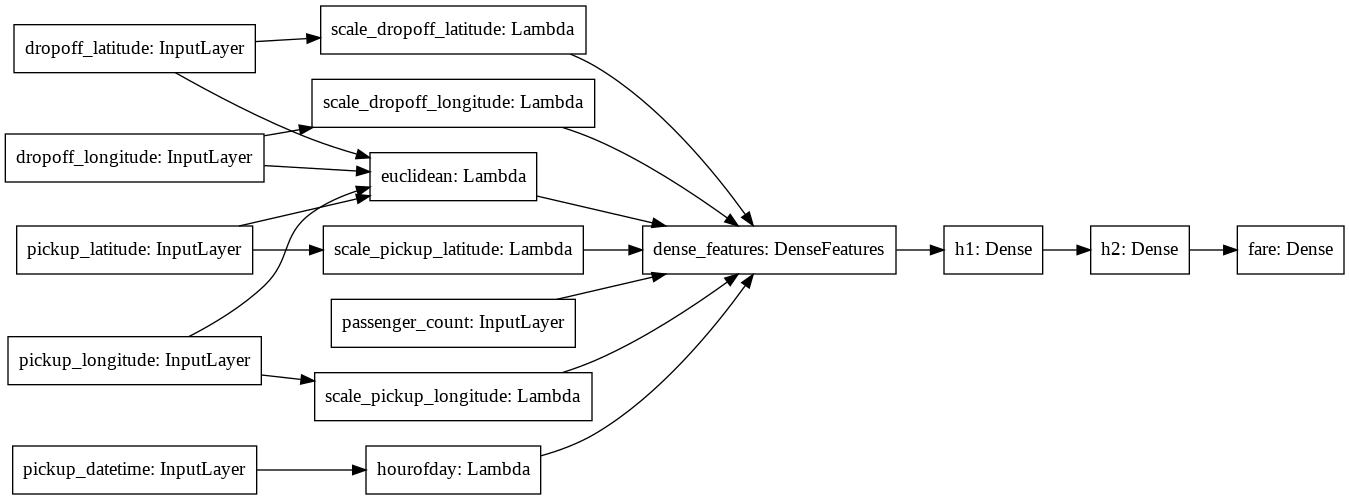

In [15]:
# Visualize the NN model
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

### Train the model

In [16]:
trainds = load_dataset('taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//10000) # evaluate on 1/10 final evaluation set

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

shutil.rmtree('{}/checkpoints/'.format(OUTDIR), ignore_errors=True)
checkpoint_path = '{}/checkpoints/taxi'.format(OUTDIR)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch,
                    verbose=2, # 0=silent, 1=progress bar, 2=one line per epoch
                    callbacks=[cp_callback])

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
Repeating training dataset indefinitely
Train for 312 steps, validate for 1 steps
Epoch 1/5

Epoch 00001: saving model to ./trained_model/checkpoints/taxi
312/312 - 7s - loss: 123.9720 - rmse: 10.3419 - mse: 123.9720 - val_loss: 89.3693 - val_rmse: 9.4535 - val_mse: 89.3693
Epoch 2/5

Epoch 00002: saving model to ./trained_model/checkpoints/taxi
312/312 - 5s - loss: 91.8040 - rmse: 9.0389 - mse: 91.8041 - val_loss: 88.2372 - val_rmse: 9.3935 - val_mse: 88.2372
Epoch 3/5

Epoch 00003: saving model to ./trained_model/checkpoints/taxi
312/312 - 5s - loss: 106

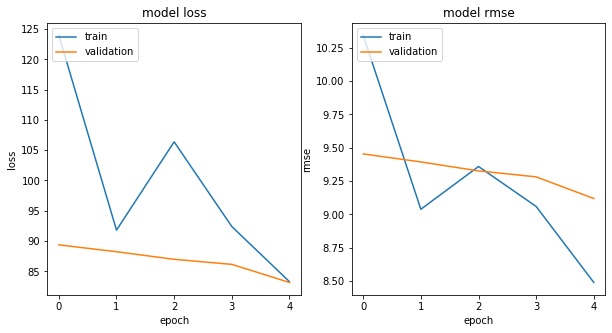

In [17]:

# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

In [26]:
# Evaluate on all the valudation set
## 1000 here is batch size
evalds = load_dataset('taxi-test*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)
model.evaluate(evalds)

10/10 [==============================] - 0s 26ms/step - loss: 95.6402 - rmse: 9.7667 - mse: 95.6402


[95.64020309448242, 9.76665, 95.64019]

### Save the Model

In [27]:
import datetime
OUTPUT_DIR = os.path.join(OUTDIR, 'export/savedmodel')
if OUTPUT_DIR[:5] != 'gs://':
    shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH) # with default serving function

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./trained_model/export/savedmodel/20200214234349/assets


In [28]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_passenger_count:0
  inputs['pickup_datetime'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_pickup_datetime:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_pickup_longitude:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['fare'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: Stateful

In [29]:
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

./trained_model/export/savedmodel/20200214234349
./trained_model/export/savedmodel/20200214234349/variables
./trained_model/export/savedmodel/20200214234349/variables/variables.index
./trained_model/export/savedmodel/20200214234349/variables/variables.data-00000-of-00001
./trained_model/export/savedmodel/20200214234349/saved_model.pb
./trained_model/export/savedmodel/20200214234349/assets


## Reference

https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/quests/serverlessml